 <h3> Decoding an Arbitrary Continuous Stimulus </h3>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

1.) In order to compute maximum likelihood and maximum a posteriori over a population, we must first define an individual neuron's response



- defining a function for gaussian tuning curves that allows us to calculate the response of a single neuron to a particular stimulus value:

In [3]:
def gauss_response(s, s0, sigma, r_max):
    return r_max*np.exp(-0.5*((s-s0)/sigma)**2)

- defining a function for poisson responses:

In [7]:
def poisson_response(r, T, k):
    return ((r*T)**k)*(np.exp(-r*T)/np.math.factorial(k))

<h4> Simulating the responses of a population of neurons: </h4>

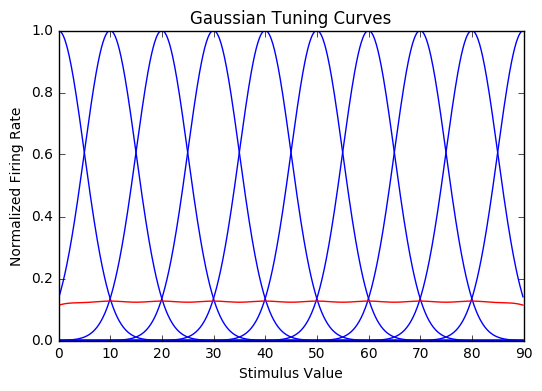

In [100]:
sigma = 5
r_max = 20
n_neurons = 10
max_s = 90
s0 = np.linspace(0, max_s, n_neurons)

s = np.arange(0, max_s, 0.1)
neuron_tuning = np.zeros((n_neurons, len(s)))

for i in range(n_neurons):
    neuron_tuning[i,:] = gauss_response(s, s0[i], sigma, r_max)
    
plt.plot(s, neuron_tuning.transpose()/r_max, c='b') # normalize by dividing y by r_max
plt.plot(s, np.mean(neuron_tuning,0)/r_max, c='r') # normalize by dividing y by r_max
plt.xlabel('Stimulus Value')
plt.ylabel('Normalized Firing Rate')
plt.title('Gaussian Tuning Curves')

plt.show()

so looking at the above graph:
- you can see our assumption that the receptive fields span the range of s uniformly
- the red line represents the total coverage of the population of neurons at a particular stimulus value s
    - if we choose some value of s (say 32) and we add up all the responses of our population of neurons, we'll get some overall firing rate which is represented by the red line (which is constant) 

<h4>Calculating the predicted firing rate of each neuron according to the tuning curve: </h4>

for this, we have to simulate 

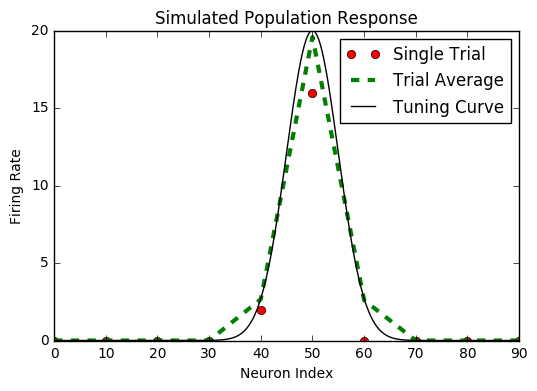

In [101]:
T = 0.5
s_test = s0[int(n_neurons/2)]
n_trials = 100

pop_spike_count = np.zeros((n_neurons, n_trials))
for n in range(n_neurons):
    rate = gauss_response(s_test, s0[n], sigma, r_max)
    pop_spike_count[n,:] = np.random.poisson(rate * 0.5, n_trials)

plt.plot(s0, pop_spike_count[:,0]/T,'or')
plt.plot(s0, np.mean(pop_spike_count,1)/T, '--g', linewidth=3)
plt.plot(s, neuron_tuning[int(n_neurons/2),:], '-k')
plt.title('Simulated Population Response')
plt.xlabel('Neuron Index')
plt.ylabel('Firing Rate')
plt.legend(['Single Trial', 'Trial Average', 'Tuning Curve'])
plt.show()

so here, a neuron with preferred orientation 45 is driven maximally while a neuron with preferred orientation 10 is not driven at all
- notice there's still a lot of variability with the simulated data -- the more trials we do the closer the responses would get to the dotted line
- and it's std. dev would be given by sqrt(r) where r = avg. firing rate (bc it's Poisson)

<h4> Time to Decode </h4>

We are trying to read out an estimate of a scalar stimulus value that was presented to the network. There are 2 good techniques for this:
- Maximum Likelihood Estimation
    - works well if the full probability distribution of responses is known
- Maximum A Posteriori Estimation

<h3> Maximum Likelihood Estimation </h3>

1. start by figuring out each neuron's individual response (assuming poisson distribution firing rate)
2. then calculate the full distribution for all the neurons at the same time
    - this expression finds the total stochastic response for a given stimuli
3. take the log of that equation (since the poisson dist formula is exponential)
4. find the value of s where that equation is maximized (take derivative with respect to s and set = to 0)
5. do that through, and you get a simplified version of the formula given by the equation below:



<i>so, we want to simulate the population response to different stimuli and test how much the true value deviates from the value predicted by maximum likelihood estimation</i>

In [102]:
ml_error = np.zeros(len(s))
for i,stim in enumerate(s):
    rates = gauss_response(stim, s0, sigma, r_max)
    
    for trial in range(n_trials):
        # Generate the population response:
        counts = np.random.poisson(rates)
        
        # Derive the predicted stimulus value
        total_count = np.sum(rates)
        weighted_count = np.sum(rates*s0)
        s_predicted = weighted_count/total_count
        
        # calculate the predicted stimulus error
        ml_error[i] += (s_predicted - stim)**2

<h3> Maximum A Posteriori Estimation </h3>

- it's pretty similar to the above

In [116]:
s_prior = 40
ml_error = 0
ma_error = 0 
    
for trial in range(n_trials):
    stim = np.random.normal(s_prior, 1)
    rates = gauss_response(stim, s0, sigma, r_max)
    
    # Generate the population response:
    counts = np.random.poisson(rates)

    # Derive the predicted stimulus value
    total_count = np.sum(rates)
    weighted_count = np.sum(rates*s0)
    ml_predicted = weighted_count/total_count
    ma_predicted = (weighted_count + s_prior)/(total_count + 1)

    # calculate the predicted stimulus error
    ml_error += np.square(ml_predicted - stim)
    ma_error += np.square(ma_predicted - stim)

print(ml_error)
print(ma_error)

1.28073657638
2.07390053942


you can see that the maximum likelihood gives slightly better performance in this model